# YOLO Inference On Taco Images

- TACO: (Trash Annotations in Context)

* A model must be trained.
    - Be located in the ./checkpoints dir.
    - And its filename must be in config.yaml, ex: "yolo_v1_taco_D_2025-07-08_EPOCH_50_LOSS_2.1525_S_448.pt".
* Run Yolo model on custom images.


In [1]:
import torch
import torchvision.transforms as T
from argparse import Namespace
import torch.optim as optim
from utils.checkpoints import load_checkpoint
from yolov1 import YOLOv1
torch.set_printoptions(threshold=torch.inf) # When printing tensors, should all values, only use in Jupyter Notebook.
torch.manual_seed(1)

In [2]:
# For Jupyter Notebook: reloads external functions when its code changes.
%load_ext autoreload
%autoreload 1 
# 0: Disables automatic reloading (default setting). 1: Reloads only modules imported using the %aimport magic command. 2: Reloads all modules (except those explicitly excluded by %aimport)

# %aimport module name will only reload those files

### Add Configurations

In [3]:
%aimport utils.load_config
from utils.load_config import load_config

config = load_config()
config

Namespace(DEVICE=device(type='mps'), NUM_WORKERS=2, PIN_MEMORY=True, EPOCHS=50, LEARNING_RATE=0.001, BATCH_SIZE=64, WEIGHT_DECAY=0, CON_TRAINING=False, LOAD_MODEL_FILE='yolo_v1_taco_D_2025-07-10_EPOCH_50_LOSS_4.4416_SIZE_448.pt', LAST_EPOCH=0, WHICH_DATASET='test-case-overfit-one-image', IMAGE_SIZE=448, C=18, B=2, S=7, IOU_THRESHOLD=0.6, MIN_THRESHOLD=0.5, NUM_NODES_PER_CELL=28, NUM_NODES_PER_IMG=1372)

### Add Transforms

In [4]:
# <------------- Transforms ------------->
class Compose(object):
    """Apply a sequence of transforms safely on (image, bboxes)."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img, bboxes)
        return img, bboxes


class Resize(object):
    """Resize the image. No change needed for bboxes since they are normalized (0-1)."""

    def __init__(self, size):
        self.size = size  # (width, height) like (448,448)

    def __call__(self, img, bboxes):
        img = T.Resize(self.size)(img)
        return img, bboxes  # bboxes stay the same


class ToTensor(object):
    """Convert image to Tensor. Leave bboxes as they are."""

    def __call__(self, img, bboxes):
        img = T.ToTensor()(img)  # Automatically normalize image between 0-1
        return img, bboxes


transforms = Compose(
    # transform object to resize the bboxes and images.  Normalize image tensors
    [
        Resize((448, 448)),  # Resize image to 448x448
        ToTensor(),  # Convert image to tensor
    ]
)

### Load Model

In [5]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

yolo = YOLOv1(in_channels=3, S=config.S, B=config.B, C=config.C).to(config.DEVICE)

optimizer = optim.Adam(
    yolo.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)

# ==> Init Learning rate scheduler with a warm-up
warm_up = LinearLR(  # warmups help prevent exploding gradients early on.
    optimizer=optimizer, start_factor=0.1, total_iters=5
)  # 10% of LR over first 5 epochs, then back to regular LR.

cosine = CosineAnnealingLR(optimizer, T_max=config.EPOCHS - 5)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warm_up, cosine],
    milestones=[5],  # switch from warm_up to cosine after epoch 5
)

# ==> Load A model.
load_checkpoint(
            file_name=config.LOAD_MODEL_FILE,
            yolo=yolo,
            optimizer=optimizer,
            scheduler=scheduler,
        )


################################################################ 

Loading Model | model_name: yolo_v1_taco_D_2025-07-10_EPOCH_50_LOSS_4.4416_SIZE_448.pt

 Saved Model Attributes:
  epoch      → 50
  model      → dict with 148 entries
  optimizer  → dict with 2 entries
  mean_loss  → 4.441633224487305

√ Loaded model.

################################################################ 



50

### Load Dataset

In [6]:
from yolov1.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

# config.MODE = "test"
dataset = Dataset(S=config.S, B=config.B, C=config.C, whichDataset=config.WHICH_DATASET, transforms=transforms)
"# of images:",dataset.__len__()

Checking csv dataframe file: csv dataframe file already exists.


('# of images:', 1)

In [7]:
img_t, label_t = dataset.__getitem__(0) # Load the image at index __(int) from the dataframe csv. Depending on the config.MODE, the dataframe will either be train.csv, valid.csv or test.csv
img_t.shape, label_t.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 28]))

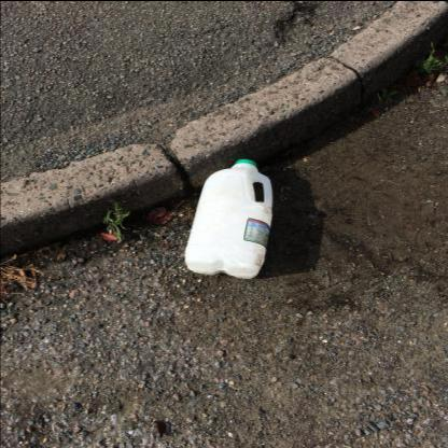

In [8]:
img = to_pil_image(img_t)
img

### Predict

In [9]:
# Add a batch to the img tensor, so that it can be feed to the model. Yolo model expects shape (BATCH_SIZE, img_channel_size, Img_Size, Img_Size).
img_t = img_t.unsqueeze(0)
img_t.shape

torch.Size([1, 3, 448, 448])

In [10]:
with torch.no_grad():
    out = yolo(img_t.to(config.DEVICE))
out, out.shape

(tensor([[[[-9.1984e-02, -6.0100e+00, -4.8473e+00, -7.4659e-02,  6.7577e+00,
             3.0184e+00, -2.0279e-01, -1.2942e-01, -7.1004e+00, -1.0353e+00,
             3.8275e+00,  3.4783e+00, -7.4210e+00, -2.7327e+00, -5.8570e+00,
            -2.6655e+00,  4.5188e+00,  1.2938e+00,  3.2832e-08,  3.2905e-04,
             1.3673e-02,  4.6281e-03,  4.2560e-01,  2.7320e-09,  2.0701e-01,
             2.3441e-01,  3.6795e-01,  1.8074e-01],
           [-2.2807e-01, -5.5176e+00,  2.5763e+00,  3.5576e-01, -5.0151e+00,
            -1.9768e+00,  1.2124e+01,  2.5480e-01, -6.5881e+00,  1.3512e+00,
             3.1023e+00, -3.0563e-01,  2.3334e+00, -5.7056e+00,  2.5390e+00,
            -7.9527e+00, -6.1495e+00, -7.5300e-01,  3.4735e-07,  8.0023e-01,
             1.0906e-03,  8.5398e-01,  6.7776e-01,  1.3415e-08,  3.6301e-01,
             3.1959e-01,  6.7167e-01,  8.5605e-02],
           [ 4.6134e+00,  8.1148e+00,  1.6161e-01,  1.2407e+00, -2.8877e+00,
             6.2947e+00, -4.2050e+00,  2.6291e+00

### Reshape Output
* Reshape output from (1, 1372) -> (1, 7, 7, 28) ->  (7, 7, 28) 
    - Remove the batch because we are only working with one image. 

In [11]:
# Reshape output
out = out.view(1, 7, 7, 28)
out = out.squeeze()
out.shape

torch.Size([7, 7, 28])

### Extract Bounding Boxes

In [12]:
%aimport utils.bboxes

from utils.bboxes import extract_bboxes, reconstruct_tensor

pred_bboxes = extract_bboxes(out, config) # (N, 9) [ i, j, b, class_idx, pc, x, y, w, h]
pred_bboxes.shape

torch.Size([98, 9])

### Compute Non-Max-Suppression
* Remove redundant bounding boxes from the models prediction.

In [13]:
%aimport utils.nms

from utils.nms import non_max_suppression

In [14]:
nms_bboxes = non_max_suppression(
    pred_bboxes=pred_bboxes,
    config=config
)

# The bboxes from the models prediction that survived NMS.
nms_bboxes.shape 

No bounding boxes has a probability score (pc) > MIN_THRESHOLD. The model is not good enough or something is wrong in code.


torch.Size([0, 9])

### Plot The Predicted And True Bounding Boxes

In [15]:
%aimport utils.plot
from utils.plot import plot_bboxes

In [16]:
label_t = label_t.to(config.DEVICE)
label_bboxes = extract_bboxes(label_t, config)

In [17]:
label_filter = label_bboxes[label_bboxes[:, 4] == 1]
label_filter, label_filter.shape # The bboxes from the label where an object is.

(tensor([[2.0000, 3.0000, 0.0000, 2.0000, 1.0000, 0.8281, 0.5409, 0.0529, 0.0192],
         [3.0000, 3.0000, 0.0000, 1.0000, 1.0000, 0.5757, 0.3990, 0.1971, 0.2668]],
        device='mps:0'),
 torch.Size([2, 9]))

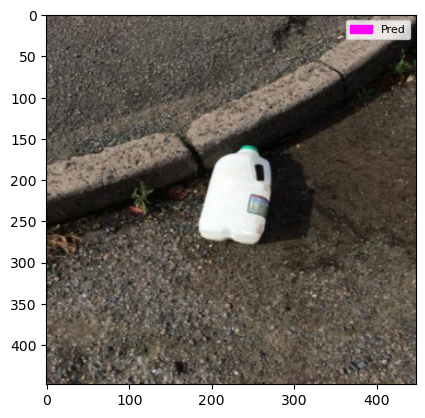

In [ ]:
plot_bboxes(img=img, label_bboxes=label_filter, pred_bboxes=nms_bboxes, S=config.S)

### Upload Image

In [19]:
def yolo_decode(output, conf_thres=0.01, S=7, B=2, C=18, img_size=448):
    """
    output : (S,S,28) -- already passed through the sigmoid where appropriate
    returns 3 tensors suited for nms_torch
    """
    cell_size = img_size / S
    boxes_list  = []
    scores_list = []
    labels_list = []

    for i in range(S):
        for j in range(S):
            cell_pred = output[i, j]                       # (28,)

            # 1) class-probabilities
            class_probs = cell_pred[:C]                    # (C,)

            # 2) the two boxes
            for b in range(B):
                base = C + b * 5                           # index of pc,x,y,w,h
                pc  = cell_pred[base]                      # objectness
                if pc < conf_thres:
                    continue                               # skip very low scores

                x, y, w, h = cell_pred[base+1:base+5]

                # convert to absolute pixel coords
                cx = (j + x) * cell_size                   # centre x in px
                cy = (i + y) * cell_size                   # centre y
                w  = w * img_size
                h  = h * img_size
                x1 = cx - w/2
                y1 = cy - h/2
                x2 = cx + w/2
                y2 = cy + h/2

                # final class-specific score and label
                cls_prob, cls_idx = class_probs.max(0)
                score = pc * cls_prob

                boxes_list.append([x1, y1, x2, y2])
                scores_list.append(score)
                labels_list.append(cls_idx)

    if len(boxes_list) == 0:
        return (torch.empty((0,4)),
                torch.empty((0,)),
                torch.empty((0,), dtype=torch.long))

    return (torch.tensor(boxes_list, dtype=torch.float32),
            torch.stack(scores_list),
            torch.stack(labels_list).long())

In [20]:
img_t.shape

torch.Size([1, 3, 448, 448])

In [21]:
import torch

def iou_torch(box_a, box_b, eps: float = 1e-6):
    """
    box_a, box_b : tensors with identical shape (..., 4)
                   containing corner-form boxes [x1, y1, x2, y2]
    returns      : IoU tensor with shape (...)

    Works with single boxes (shape [4]), batches ([N,4]),
    or any number of leading dimensions.
    """

    # intersection rectangle
    xi1 = torch.max(box_a[..., 0], box_b[..., 0])
    yi1 = torch.max(box_a[..., 1], box_b[..., 1])
    xi2 = torch.min(box_a[..., 2], box_b[..., 2])
    yi2 = torch.min(box_a[..., 3], box_b[..., 3])

    inter_w = (xi2 - xi1).clamp(min=0)
    inter_h = (yi2 - yi1).clamp(min=0)
    inter_area = inter_w * inter_h

    # areas of the individual boxes
    area_a = (box_a[..., 2] - box_a[..., 0]).clamp(min=0) * \
             (box_a[..., 3] - box_a[..., 1]).clamp(min=0)
    area_b = (box_b[..., 2] - box_b[..., 0]).clamp(min=0) * \
             (box_b[..., 3] - box_b[..., 1]).clamp(min=0)

    union = area_a + area_b - inter_area
    return inter_area / (union + eps)

In [22]:
import torch
from typing import Optional, List

def nms_torch(
        boxes:  torch.Tensor,   # (N,4)  x1,y1,x2,y2  in pixels
        scores: torch.Tensor,   # (N,)
        labels: Optional[torch.Tensor] = None,  # (N,)  class ids
        iou_thresh: float = 0.50,
        keep_top: Optional[int] = None
) -> List[int]:
    """
    Pure-PyTorch, class-aware Non-Max Suppression.
    Returns a Python list with indices of the survivors in **descending
    score** order.
    """

    if boxes.numel() == 0:
        return []

    if labels is None:                                     # class-agnostic
        labels = torch.zeros_like(scores, dtype=torch.long)

    # 1) sort by score
    order = scores.argsort(descending=True)
    keep  = []

    while order.numel() > 0:
        i = order[0].item()                                # current best
        keep.append(i)

        if keep_top is not None and len(keep) >= keep_top:
            break

        rest        = order[1:]
        same_class  = labels[rest] == labels[i]            # (M,)
        ious        = iou_torch(boxes[i].unsqueeze(0),     # (1,4) vs (M,4)
                                boxes[rest]).squeeze(0)    # ⇒ (M,)

        # keep boxes of *other* classes OR with IoU < thresh
        mask = (~same_class) | (ious < iou_thresh)
        order = rest[mask]

    return keep


def non_max_suppression(pred_bboxes, config):
    """
    Computes NMS by filtering out overlapping bboxes per class.

    Note:
        Non-Maximum Suppression (NMS) is a vital post-processing step in many computer vision tasks, particularly in object detection. It is used to refine predictions of object detection models by eliminating redundant bounding boxes and ensuring that each object is detected only once.

    Args:
        pred_bboxes (Tensor): (N, 9) [ i, j, b, class_idx, pc, x, y, w, h]
            - x,y are cell-relative ∈ [0,1];  w,h are image-relative ∈ [0,1].

        config : Namespace configurations.
            Project configurations.

    Variables:
        IOU_threshold (float) : the iou threshold when comparing bounding boxes for NMS.

        min_threshold (float) : the threshold to remove bounding boxes with a low confidence score.
    Returns:
        Tensor : (M, 9) with filtered bboxes.
    """

    S, IOU_THRESHOLD, MIN_THRESHOLD = (
        config.S,
        config.IOU_THRESHOLD,
        config.MIN_THRESHOLD,
    )

    # === 1: Filter out low-confidence bboxes; tensors where pc/probability_score (column 4) is less than min_threshold.
    # TODO fix below line
    keep_mask = pred_bboxes[:, 4] > MIN_THRESHOLD
    bboxes = pred_bboxes[keep_mask]

    #   Return if no boxes survives.
    if bboxes.numel() == 0:
        print(
            "No bounding boxes has a probability score (pc) > MIN_THRESHOLD. The model is not good enough or something is wrong in code."
        )
        return bboxes

    # === 2: Convert midpoint coords (x, y, w, h) -> corner-point coordinates (x1, y1, x2, y2).
    i, j = bboxes[:, 0], bboxes[:, 1]
    cx = (j + bboxes[:, 5]) / S
    cy = (i + bboxes[:, 6]) / S
    w, h = bboxes[:, 7], bboxes[:, 8]

    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    corners = torch.stack([x1, y1, x2, y2], dim=1)

    # === 3: Perform class-wise NMS
    final_idx = []
    for cls in bboxes[:, 3].unique():
        cls_mask = bboxes[:, 3] == cls
        cls_boxes = corners[cls_mask]
        cls_scores = bboxes[cls_mask, 4]  # pc
        # TODO I need to do the NMS line below myself instead of calling from a library
        keep = nms(cls_boxes, cls_scores, IOU_THRESHOLD)
        base_idx = torch.nonzero(cls_mask, as_tuple=False).squeeze(1)
        final_idx.append(base_idx[keep])

    final_idx = torch.cat(final_idx)
    return bboxes[final_idx]

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Sequence
import torch
from PIL import Image

# ------------------------------------------------------------
# put your 18 class names here in index order
CLASSES = [
    "Aluminum foil",
    "Bottle",
    "Bottle cap",
    "Broken glass",
    "Can",
    "Carton",
    "Cigarette",
    "Cup",
    "Lid",
    "Other litter",
    "Other plastic",
    "Paper",
    "Plastic bag & wrapper",
    "Plastic container",
    "Pop tab",
    "Straw",
    "Styrofoam piece",
    "Unlabeled litter",
]
# ------------------------------------------------------------


def plot_detections(
        img:         Image.Image,
        boxes:       torch.Tensor,        # (N,4) x1,y1,x2,y2  in **pixels**
        scores:      torch.Tensor,        # (N,)
        labels:      torch.Tensor,        # (N,)
        score_thres: float = 0.01,
        colors:      Sequence[str] = ("magenta", "cyan", "lime", "yellow"),
        linewidth:   int = 2,
):
    """
    Simple visualisation – draws every box whose score >= score_thres.
    One colour per class (cycled).
    """

    assert boxes.shape[0] == scores.shape[0] == labels.shape[0]

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.axis("off")

    for i in range(boxes.shape[0]):

        if scores[i] < score_thres:
            continue

        x1, y1, x2, y2 = boxes[i].tolist()
        cls             = int(labels[i])
        colour          = colors[cls % len(colors)]

        # rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=linewidth, edgecolor=colour, facecolor='none'
        )
        ax.add_patch(rect)

        # text
        caption = f"{CLASSES[cls]} {scores[i]:.2f}"
        ax.text(
            x1,
            y1 - 4,                      # a few pixels above
            caption,
            fontsize=8,
            color=colour,
            va="bottom",
            bbox=dict(
                facecolor="black",
                alpha=0.35,
                edgecolor="none",
                pad=1.0
            ),
        )

    plt.show()

In [24]:
# forward pass on ONE image
with torch.no_grad():
    net_out = yolo(img_t.to(config.DEVICE))[0].cpu()  # → (7,7,28)
print(net_out.shape) # SHAPE torch.Size([7, 7, 28])

# decode
boxes, scores, labels = yolo_decode(net_out, conf_thres=0.05,
                                    S=7, B=2, C=18, img_size=448)

# NMS
keep_idx = nms_torch(boxes, scores, labels,
                     iou_thresh=0.5, keep_top=100)
keep_idx

torch.Size([7, 7, 28])


[0]

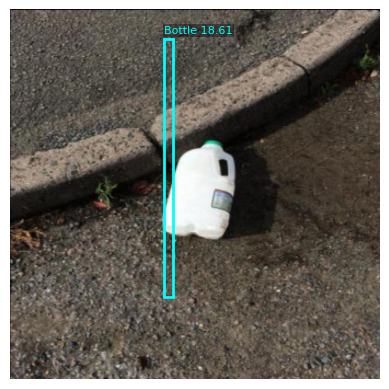

In [25]:

boxes   = boxes [keep_idx]
scores  = scores[keep_idx]
labels  = labels[keep_idx]

plot_detections(img, boxes, scores, labels, score_thres=0.05)
